In [1]:
import oda_api.token 
import logging
import numpy as np
from oda_api.api import DispatcherAPI
from oda_api.plot_tools import OdaImage, OdaLightCurve, OdaSpectrum
import matplotlib.pyplot as plt
import astroquery.heasarc
from astropy.wcs import WCS
from astropy.io import fits
from astroquery.simbad import Simbad
from astropy import coordinates as coord
from astropy.coordinates import SkyCoord
from astropy.time import Time
from matplotlib.patches import Circle

In [2]:
# token = ''
# token = getpass.getpass('Insert the token')
token = oda_api.token.discover_token() # get token stored locally

In [3]:
logging.getLogger().setLevel(logging.INFO) # WARNING, INFO or DEBUG
logging.getLogger('oda_api').addHandler(logging.StreamHandler())

In [4]:
source_name = 'Crab'

Heasarc = astroquery.heasarc.Heasarc()

def get_scw_list(ra_obj, dec_obj, radius):
    R = Heasarc.query_region(
            position = SkyCoord(ra_obj, dec_obj, unit='deg'),
            radius = f"{radius} deg",
            catalog = 'intscw',
            good_isgri = ">1000",
        )
    R.sort('scw_id') 
    return R['scw_id'], R['scw_ver'], R['start_date'], R['end_date']

assert astroquery.__version__ >= '0.4.2.dev6611'
assert 'isdc' in astroquery.heasarc.Conf.server.cfgtype

result_table = Simbad.query_object(source_name)
source_coord = coord.SkyCoord(result_table['ra'][0], result_table['dec'][0], unit=("hourangle", "deg"))
ra=source_coord.ra.deg
dec=source_coord.dec.deg
radius=8.

scwlist,version,start,end = get_scw_list(ra,dec,radius)

In [33]:
scw = [(s+"."+v).strip() for s,v in zip(scwlist,version) if s.endswith('0')]
pick = np.random.randint(0,len(scw))
scw_pick = scw[pick]
start_pick = start[pick]
end_pick = end[pick]
duration = Time(end_pick - start_pick, format='mjd').isot
print(duration)

1858-11-17T00:41:20.002


In [34]:
disp = DispatcherAPI(url="https://www.astro.unige.ch/mmoda/dispatch-data", instrument="mock")

if Time(start[pick], format='mjd').isot > '2016':
    osa_version = "OSA11.2"
else:
    osa_version = "OSA10.2"

par_dict = {
"E1_keV": "15",
"E2_keV": "30",
"T_format": "isot",
"detection_threshold": "5",
"instrument": "isgri",
"osa_version": osa_version,
"product": "isgri_image",
"product_type": "Real",
"scw_list": scw_pick,
'token': token
}

data_collection = disp.get_product(**par_dict)
data_collection.show()

please beware that by default, in a typical setup, oda_api will not output much. To learn how to increase the verbosity, please refer to the documentation: https://oda-api.readthedocs.io/en/latest/user_guide/ScienceWindowList.html?highlight=logging#Let's-get-some-logging . 
To disable this message you can pass `.get_product(..., silent=True)`
- waiting for remote response (since 2025-03-11 13:19:13), please wait for https://www.astro.unige.ch/mmoda/dispatch-data/run_analysis
session: F1CF4L1BU6MFZY13 job: 211a68ce0a6e2a5e

... query status prepared => submitted
... assigned job id: 211a68ce0a6e2a5e
 | the job is working remotely, please wait status=submitted job_id=211a68ce in 0 messages since 5 seconds (5.3/5.3); in 0 SCW so far; nodes (0): 0 computed 0 restored
... 
- waiting for remote response (since 2025-03-11 13:19:19), please wait for https://www.astro.unige.ch/mmoda/dispatch-data/run_analysis
session: F1CF4L1BU6MFZY13 job: 211a68ce0a6e2a5e
 / the job is working remotely, please

ID=0 prod_name=mosaic_image_0_mosaic  meta_data: {'product': 'mosaic', 'instrument': 'isgri', 'src_name': '', 'query_parameters': None}

ID=1 prod_name=dispatcher_catalog_1  meta_data: 



IMAGE

In [35]:
data_collection.mosaic_image_0_mosaic.show()
print(data_collection.mosaic_image_0_mosaic.show_meta())
data_collection.dispatcher_catalog_1.table

------------------------------
name: mosaic_image
meta_data dict_keys(['product', 'instrument', 'src_name', 'query_parameters'])
number of data units 6
------------------------------
data uniti 0 ,name: PRIMARY
data uniti 1 ,name: GROUPING
data uniti 2 ,name: ISGR-MOSA-IMA
data uniti 3 ,name: ISGR-MOSA-IMA
data uniti 4 ,name: ISGR-MOSA-IMA
data uniti 5 ,name: ISGR-MOSA-IMA
------------------------------
product : mosaic
instrument : isgri
src_name : 
query_parameters : None
------------------------------
None


meta_ID,src_names,significance,ra,dec,NEW_SOURCE,ISGRI_FLAG,FLAG,ERR_RAD
,,,deg,deg,,,,
float64,float64,float64,float64,float64,float64,float64,float64,float64


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set MJD-OBS to 54795.784317 from DATE-OBS.
Set MJD-END to 54795.794572 from DATE-END'. [astropy.wcs.wcs]
/home/hthums/micromamba/envs/jupiter_xray/lib/python3.9/site-packages/oda_api/plot_tools.py:101: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()


'./../data/Crab-074700260010.001mosaic.fits'

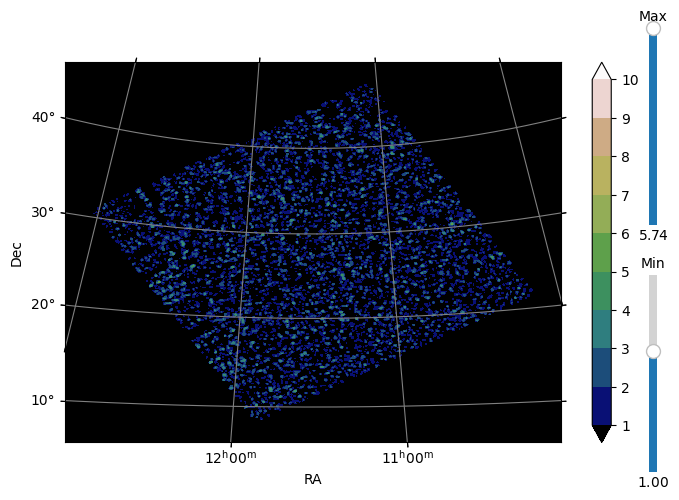

In [36]:
im=OdaImage(data_collection)
_ = im.show()
im.write_fits(f"../data/Crab-{scw_pick}")

Plot from the fits file.

Filename: ../data/Crab-074700260010.001mosaic.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       6   ()      
  1  GROUPING      1 BinTableHDU     82   4R x 16C   [8A, 32A, 1J, 1J, 256A, 3A, 32A, 1I, 1I, 1E, 1E, 1E, 1D, 1D, 1D, 1D]   
  2  ISGR-MOSA-IMA    1 ImageHDU        67   (551, 551)   float32   
  3  ISGR-MOSA-IMA    2 ImageHDU        67   (551, 551)   float32   
  4  ISGR-MOSA-IMA    3 ImageHDU        67   (551, 551)   float32   
  5  ISGR-MOSA-IMA    4 ImageHDU        67   (551, 551)   float32   


XTENSION= 'IMAGE   '           / Image extension                                
BITPIX  =                  -32 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                  551                                                  
NAXIS2  =                  551                                                  
PCOUNT  =                   

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set MJD-OBS to 54795.784317 from DATE-OBS.
Set MJD-END to 54795.794572 from DATE-END'. [astropy.wcs.wcs]
/tmp/ipykernel_1531/826088056.py:23: RuntimeWarning: divide by zero encountered in log10
  im = ax.imshow(np.log10(image_data), cmap='plasma', origin='lower')
/tmp/ipykernel_1531/826088056.py:23: RuntimeWarning: invalid value encountered in log10
  im = ax.imshow(np.log10(image_data), cmap='plasma', origin='lower')


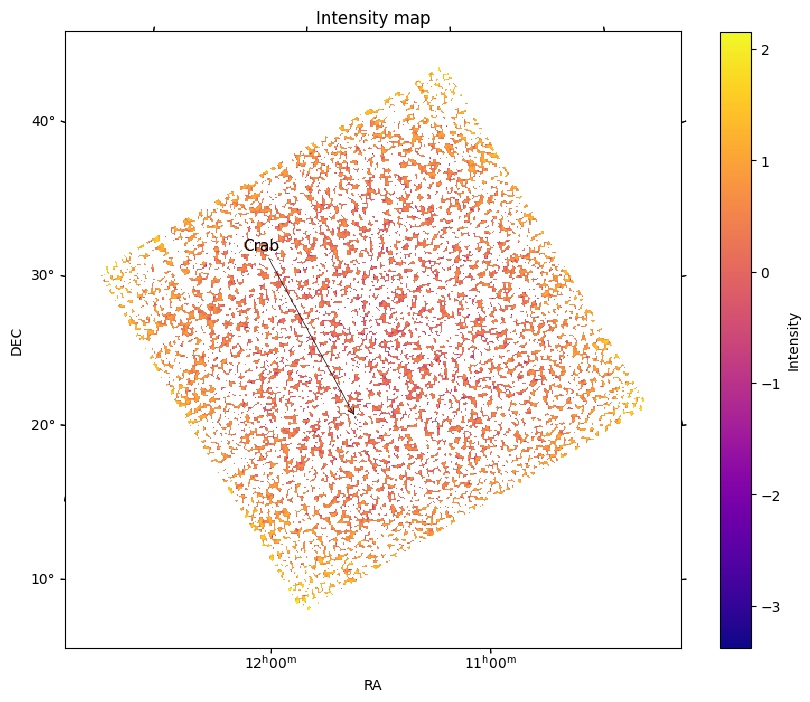

In [37]:
fits_file = f"../data/Crab-{scw_pick}"+"mosaic.fits"

pick = 2  # 2 for image, 3 for variance, 4 for significance and 5 for exposure map

with fits.open(fits_file) as hdul:
    hdul.info()
    intensity_data = hdul[2].data 
    variance_data = hdul[3].data
    significance_data = hdul[4].data
    exposure_data = hdul[5].data
    print("\n")
    print(repr(hdul[pick].header))
    print("\n")
    print(hdul[1].data.columns)
    wcs = WCS(hdul[pick].header)  
    CD1 = np.abs(hdul[pick].header["CD1_1"])

data = [intensity_data, variance_data, significance_data, exposure_data]
image_data = data[pick-2]

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection=wcs)
im = ax.imshow(np.log10(image_data), cmap='plasma', origin='lower')

ax.set_xlabel('RA')
ax.set_ylabel('DEC')

x, y = wcs.all_world2pix(ra, dec, 1)

pixel_scale = CD1 * 3600  # pixel size in arcseconds (|CD1_1| from fits header)
circle_radius_pixels = 7 * 60 / pixel_scale / 2 

circle = Circle((x, y), circle_radius_pixels, edgecolor='black', facecolor='none', lw = 0.5)
ax.add_patch(circle)

ax.annotate(
        text="Crab", 
        xy=(x, y),  
        xytext=(x - 100, y + 150),
        arrowprops=dict(arrowstyle="->", color="black", lw=0.5),
        fontsize=11,
        color="black"
    )

title = ""
if pick == 2:
    title = "Intensity"
elif pick == 3:
    title = "Variance"
elif pick == 4:
    title = "Significance"
elif pick == 5:
    title = "Exposure"

plt.title(title+" map")
plt.colorbar(im, label="Intensity")

plt.savefig(f"../data/{scw_pick}"+"_"+f"{title}.pdf", format='pdf', bbox_inches='tight')

Countrate to flux conversion (method of E. Jourdain using ISGRI calibration).

Crab count rate: -0.6865055 counts/sec
Analytically calculated photon flux: 0.2501898870399915 ph/cm2/s
Numerically calculated photon flux: 0.2502236796064092 ph/cm2/s
Numerically calculated energy flux: 8.296223349642631e-09 erg/cm2/s
Flux per count = energy per photon: 3.315522880445298e-08 erg/photon

To convert countrate to flux, multiply countrate by flux per count: 
Conversion factor: -0.3644889675048777 for ph/cm2/s or -1.2084715114323046e-08 for erg/cm2/s


Text(0, 0.5, 'Flux ($ph.cm^{-2}.s^{-1}/keV$)')

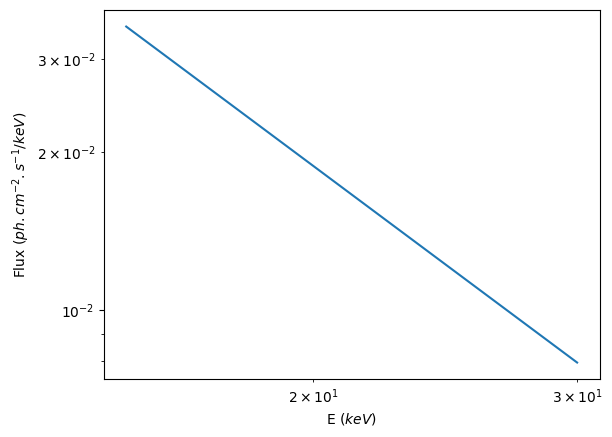

In [38]:
E0 = 100 # 100 keV reference energy
K = 6.2e-4 # flux @ 100 keV (photons/cm2/s), roughly the same for each instrument
E = np.linspace(15, 30)
gamma = 2.12 # photon index of ISGRI (2.105 for SPI+ISGRI+JEM-X)

power_law = K * (E/E0)**(-gamma) # flux

x_int, y_int = int(round(x.item())), int(round(y.item()))

crab_countrate = intensity_data[y_int, x_int]

print("Crab count rate:", crab_countrate, "counts/sec")

ph_flux = - K * (E0)**(gamma) / (gamma-1) * ((30)**(1-gamma) - (15)**(1-gamma)) # analytic
ph_flux_num = np.trapz(power_law, E) # numeric
ph_flux_num_erg = np.trapz(power_law*E*1.60218e-9, E) # numeric, energy units

print(f'Analytically calculated photon flux: {ph_flux} ph/cm2/s')
print(f'Numerically calculated photon flux: {ph_flux_num} ph/cm2/s')
print(f'Numerically calculated energy flux: {ph_flux_num_erg} erg/cm2/s')
print(f'Flux per count = energy per photon: {ph_flux_num_erg/ph_flux_num} erg/photon')
print('\nTo convert countrate to flux, multiply countrate by flux per count:',
      f'\nConversion factor: {ph_flux_num/crab_countrate} for ph/cm2/s or {ph_flux_num_erg/crab_countrate} for erg/cm2/s')

plt.figure()
plt.loglog(E, power_law)
plt.xlabel('E ($keV$)')
plt.ylabel('Flux ($ph.cm^{-2}.s^{-1}/keV$)')